In [1]:
from torch.utils.data import Dataset, DataLoader

import os
from datasets import load_dataset, load_dataset_builder
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
import numpy as np
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:40055/")

os.environ["MLFLOW_EXPERIMENT_NAME"] = "ko-en-mt"
os.environ["MLFLOW_TRACKING_URI"]="http://127.0.0.1:40055"
os.environ["MLFLOW_TRACKING_USERNAME"]="user"
os.environ["MLFLOW_TRACKING_PASSWORD"]="euvnBwWALP"

model_checkpoint = "Helsinki-NLP/opus-mt-ko-en"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, return_tensors="pt")

# MinIO 스토리지 설정
MINIO_SERVER = "http://127.0.0.1:38001"
ACCESS_KEY = "admin"  # MinIO access key
SECRET_KEY = "8KW4cWXuGc"  # MinIO secret key
BUCKET_NAME = "ko-en-mt-tech"
FILE_PATH = "parquet/train/*.parquet"    # Parquet 파일 경로 (와일드카드 가능)
MAX_LENGTH = 512

# 환경 변수로 MinIO 인증 정보 설정
os.environ["AWS_ACCESS_KEY_ID"] = ACCESS_KEY
os.environ["AWS_SECRET_ACCESS_KEY"] = SECRET_KEY

# MinIO 설정
storage_options={
        "key": ACCESS_KEY,
        "secret": SECRET_KEY,
        "client_kwargs": {
            "endpoint_url": MINIO_SERVER,
        }
    }

S3_BUCKET = f"s3://ko-en-mt-tech/parquet"  # MinIO 버킷 및 파일 경로

dataset = load_dataset('parquet', data_files=S3_BUCKET + f"/train/*.parquet", storage_options=storage_options)
idx = np.arange(len(dataset['train']), dtype=int)
np.random.shuffle(idx)
idx = idx[:len(idx)//40]
dataset['train'] = dataset['train'].select(idx)

dataset['test'] = load_dataset('parquet', data_files=S3_BUCKET + f"/valid/*.parquet", storage_options=storage_options)['train']
idx = np.arange(len(dataset['test']), dtype=int)
np.random.shuffle(idx)
idx = idx[:len(idx)//100]
dataset['test'] = dataset['test'].select(idx)

def preprocessing_function(examples):    
    # print(examples)
    # inputs = [ex["ko"] for ex in examples["translation"]]
    # targets = [ex["en"] for ex in examples["translation"]]
    model_inputs = tokenizer(examples['ko'], text_target=examples['en'], max_length=MAX_LENGTH, truncation=True, padding=True,)
    return model_inputs

# 데이터셋 전처리
tk_dataset = dataset.map(preprocessing_function, 
                                batched=True, num_proc=16, 
                                # remove_columns=dataset["train"].column_names
                            )
                        

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
# DataCollator 준비 (lazy loading 지원)
# data_collator = DataCollatorForSeq2Seq(tokenizer, model=None, padding=True)

# # DataLoader 생성
# train_dataloader = DataLoader(
#     tk_train["train"],
#     batch_size=16,  # 배치 크기 설정
#     shuffle=True,
#     collate_fn=data_collator
# )

import evaluate

sacreblue = evaluate.load("sacrebleu")

import numpy as np
from transformers import TrainerCallback


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [[label.strip()] for label in decoded_labels]

    result = sacreblue.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["score"]}
from transformers import Seq2SeqTrainingArguments

args = Seq2SeqTrainingArguments(
    
    f"marian-finetuned-kde4-ko-to-en",
    report_to="mlflow",
    # eval_strategy="steps",
    # eval_steps=50,
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=80,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    bf16=True,
    push_to_hub=False,
    eval_on_start=False,
    logging_steps=10,
    torch_compile=False,
    do_train=True,
    max_steps=10
)

from transformers import Seq2SeqTrainer
from transformers import pipeline



# trainer.add_callback(MLflowCallback())
mlflow.transformers.autolog()
# Start MLflow run
with mlflow.start_run() as run:
    trainer = Seq2SeqTrainer(
        model,
        args,
        train_dataset=tk_dataset["train"],
        eval_dataset=tk_dataset["test"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train the model
    trainer.train()
    components = {
        "model": model,
        "tokenizer": tokenizer,
    }
    # Log model
    mlflow.transformers.log_model(
        transformers_model=components,
        artifact_path="model",
        tokenizer=tokenizer,
        # input_example={"input_ids": np.array([0, 1, 2]), "attention_mask": np.array([1, 1, 1])},
        signature=None,
        extra_pip_requirements=["torch", "transformers", "datasets", "evaluate"]
    )
    
    # Log artifacts (e.g., model checkpoints)
    # model_checkpoint_path = "../marian-finetuned-kde4-ko-to-en"  # Replace with actual path
    # mlflow.log_artifact(model_checkpoint_path, artifact_path="model_checkpoints")
    

/home/user/k8s/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map (num_proc=16): 100%|██████████| 1500/1500 [00:00<00:00, 6029.78 examples/s]
2025/01/28 00:21:26 WARNING mlflow.utils.autologging_utils: MLflow transformers autologging is known to be compatible with 4.25.1 <= transformers <= 4.48.0, but the installed version is 4.48.1. If you encounter errors during autologging, try upgrading / downgrading transformers to a compatible version, or try upgrading MLflow.
/tmp/ipykernel_943284/1549214148.py:143: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss
10,1.644800


/home/user/k8s/.venv/lib/python3.12/site-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 6, 'bad_words_ids': [[65000]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Device set to use cuda:0


🏃 View run glamorous-sloth-107 at: http://127.0.0.1:40055/#/experiments/1/runs/23d70a6a81704ae9a387d58567f91a91
🧪 View experiment at: http://127.0.0.1:40055/#/experiments/1


In [2]:

def get_embedding(sentence : str, tokenizer, model : AutoModelForSeq2SeqLM):
    import torch
    # 3. 토크나이저로 입력 데이터 전처리
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')

    print(inputs['input_ids'].device)

    # 4. 모델에 입력 전달
    with torch.no_grad():  # 그래디언트 계산 비활성화 (임베딩 추출이므로)
        enc = model.get_encoder()
        outputs = enc(**inputs)
        
    sentence_embedding = outputs.last_hidden_state
    return sentence_embedding

# tuned_pipeline = pipeline(
#     task="translation",
#     model=trainer.model,
#     batch_size=8,
#     tokenizer=tokenizer
# )

# # 3. 평가 데이터셋 예측
# to_slice = 50
# eval_set = tk_dataset['test']['ko'][:to_slice]
# predictions = tuned_pipeline(eval_set)
# scores = [sacreblue.compute(predictions=pred['translation_text'], references=target) for pred, target in zip(predictions, tk_dataset['test']['en'][:to_slice])]



In [12]:
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

['NanumGothic',
 'NanumMyeongjo',
 'NanumSquare',
 'NanumSquareRound',
 'NanumGothic',
 'NanumGothicCoding',
 'NanumBarunGothic',
 'NanumSquare',
 'NanumGothicCoding',
 'NanumMyeongjo',
 'NanumBarunGothic',
 'NanumSquareRound']

In [3]:
import matplotlib.font_manager
font_list = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
[matplotlib.font_manager.FontProperties(fname=font).get_name() for font in font_list if 'Nanum' in font]

import matplotlib.pyplot as plt
plt.rc('font', family='Ubuntu')

import seaborn as sns
import matplotlib.pyplot as plt


sns.set_theme(font="Ubuntu", 
rc={"axes.unicode_minus":False}, style='white')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams['font.family'] = 'Ubuntu'

In [4]:
def calculate_paired_similarities(inputs: list[str], targets: list[str], tokenizer, model):
    import torch
    import torch.nn.functional as F
    assert len(inputs) == len(targets), "Input and target lists must have the same length"
    
    similarities = []
    similarity_matrices = []
    
    for input_sent, target_sent in zip(inputs, targets):
        # Get embeddings
        input_emb = get_embedding(input_sent, tokenizer, model).squeeze(0)
        target_emb = get_embedding(target_sent, tokenizer, model).squeeze(0)
        
        # Calculate similarity matrix
        similarity_matrix = F.cosine_similarity(
            input_emb.unsqueeze(1),
            target_emb.unsqueeze(0),
            dim=2
        )
        
        # Calculate directional similarities
        input_to_target = similarity_matrix.max(dim=1)[0].mean().item()
        target_to_input = similarity_matrix.max(dim=0)[0].mean().item()
        
        # Overall similarity as average of both directions
        overall_similarity = (input_to_target + target_to_input) / 2
        
        similarities.append({
            'input_to_target': input_to_target,
            'target_to_input': target_to_input,
            'overall': overall_similarity
        })
        similarity_matrices.append(similarity_matrix)
    
    return similarities, similarity_matrices

def print_paired_analysis(inputs: list[str], targets: list[str], similarities: list):
    print("\nPaired Sentence Analysis:")
    print("-" * 80)
    
    for i, (input_sent, target_sent, sim) in enumerate(zip(inputs, targets, similarities)):
        print(f"\nPair {i+1}:")
        print(f"Input:  {input_sent}")
        print(f"Target: {target_sent}")
        print(f"Overall similarity: {sim['overall']:.4f}")
        print(f"Input→Target similarity: {sim['input_to_target']:.4f}")
        print(f"Target→Input similarity: {sim['target_to_input']:.4f}")
        print("-" * 80)


/home/user/k8s/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/k8s/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44544 (\N{HANGUL SYLLABLE GEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/k8s/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/k8s/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/k8s/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans

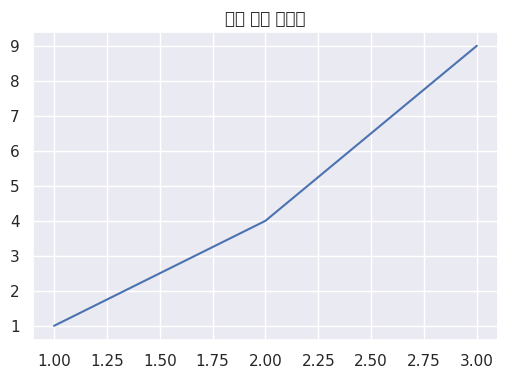

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프를 그리기 전에 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'

# 테스트 그래프
sns.set(style="darkgrid")
plt.figure(figsize=(6, 4))
sns.lineplot(x=[1, 2, 3], y=[1, 4, 9])
plt.title('한글 제목 테스트')
plt.show()


cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0

Paired Sentence Analysis:
--------------------------------------------------------------------------------

Pair 1:
Input:  배가 고프다
Target: 저는 배가 고픕니다
Overall similarity: 0.6442
Input→Target similarity: 0.6925
Target→Input similarity: 0.5960
--------------------------------------------------------------------------------

Pair 2:
Input:  밥을 먹고 싶다
Target: 점심을 먹고 싶어요
Overall similarity: 0.6965
Input→Target similarity: 0.6965
Target→Input similarity: 0.6965
--------------------------------------------------------------------------------

Pair 3:
Input:  치킨이 먹고 싶네요
Target: 저녁에 치킨을 먹을까요?
Overall similarity: 0.6123
Input→Target similarity: 0.6750
Target→Input similarity: 0.5496
--------------------------------------------------------------------------------


/home/user/k8s/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) Ubuntu.
  fig.canvas.draw()
/home/user/k8s/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51200 (\N{HANGUL SYLLABLE JEO}) missing from font(s) Ubuntu.
  fig.canvas.draw()
/home/user/k8s/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) Ubuntu.
  fig.canvas.draw()
/home/user/k8s/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from font(s) Ubuntu.
  fig.canvas.draw()
/home/user/k8s/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) Ubuntu.
  fig.canvas.draw()
/home/user/k8s/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from font(s) U

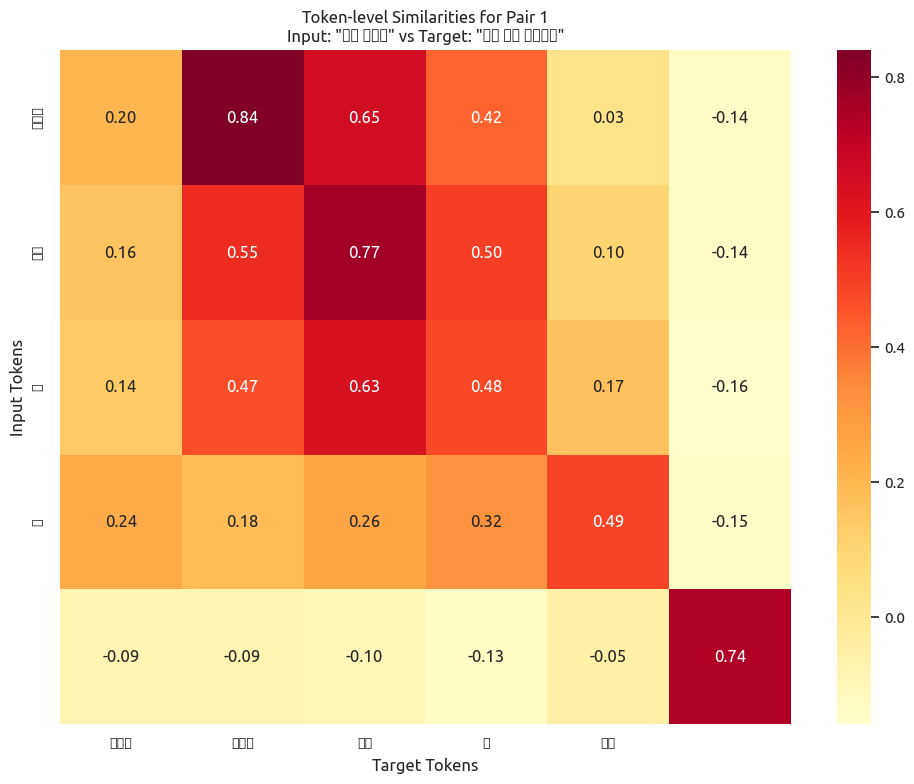

In [27]:

# Example usage:
inputs = [
    "배가 고프다",
    "밥을 먹고 싶다",
    "치킨이 먹고 싶네요"
]

targets = [
    "저는 배가 고픕니다",
    "점심을 먹고 싶어요",
    "저녁에 치킨을 먹을까요?"
]

# Calculate similarities
similarities, similarity_matrices = calculate_paired_similarities(inputs, targets, tokenizer, model)

# Print analysis
print_paired_analysis(inputs, targets, similarities)

# Optional: If you want to visualize token-level similarities for a specific pair
def plot_token_similarity(input_sent: str, target_sent: str, similarity_matrix, tokenizer, pair_idx: int):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    input_tokens = tokenizer.tokenize(input_sent)
    target_tokens = tokenizer.tokenize(target_sent)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix.cpu().numpy(),
                xticklabels=target_tokens,
                yticklabels=input_tokens,
                cmap='YlOrRd',
                annot=True,
                fmt='.2f')
    plt.title(f'Token-level Similarities for Pair {pair_idx+1}\nInput: "{input_sent}" vs Target: "{target_sent}"')
    plt.xlabel('Target Tokens')
    plt.ylabel('Input Tokens')
    plt.tight_layout()
    plt.show()

# Example: Plot token similarities for the first pair
plot_token_similarity(inputs[0], targets[0], similarity_matrices[0], tokenizer, 0)